# Montreal Fire Risk Prediction

Here, We try to prepare a panel dataset for predicting neighborhood fire risk in Montreal.

**Output:**
- Binary target variable: Whether a neighborhood experiences at least one fire in a given month
- Spatial structure: Use the census tract division from census data
- Temporal structure: Monthly time series (2005-09 onwards)
- Features: Building characteristics, temporal lags, seasonality, spatial lags

**Data Sources:**
1. Fire incidents: `Data/sim_combined_df.csv`
2. Buildings: `Data/montreal_dataset_v1.geojson`
3. Census: `Data/census/census_ct_cleaned.shp`

# Import

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score,
    accuracy_score, balanced_accuracy_score
)
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
pwd

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Set wd
#%cd "/content/drive/MyDrive/MCGILL_PROJECT_CAPSTONE/Capstone Project- McGill/Data/"
%cd "/content/drive/MyDrive/Capstone Project- McGill/Data/"
#%cd "/content/drive/MyDrive/Sam_McGill_Project_Team3"

#os.chdir("/mnt/g/My Drive/Capstone Project- McGill")
print(f"Working directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1cjGueRxhJIuCh3nhzWM6e9qcx9HjD76J/Capstone Project- McGill/Data
Working directory: /content/drive/.shortcut-targets-by-id/1cjGueRxhJIuCh3nhzWM6e9qcx9HjD76J/Capstone Project- McGill/Data


In [ ]:
!ls

 20Oct25_2ndPresentation
 22Oct_feature_importance_roe.csv
 22Oct_final_rf_model_roe.pkl
 22Oct_october_2025_predictions.csv
 22_Oct_roe_all_predictions.csv
 22_Oct_roe_metrics.csv
 25_Oct_feature_importance_roe.csv
 25_Oct_final_rf_model_roe.pkl
 25_Oct_october_2025_predictions.csv
 25_Oct_roe_all_predictions.csv
 25_Oct_roe_metrics.csv
 census
 CodeUsing_montreal_dataset_v1_geojson.ipynb
 Data
 donneesouvertes-interventions-sim-2005-2014.csv
 donneesouvertes-interventions-sim_2015_2022.csv
 donneesouvertes-interventions-sim2020_2023.csv
 donneesouvertes-interventions-sim2020_2023.gsheet
 donneesouvertes-interventions-sim2020.gsheet
 donneesouvertes-interventions-sim_2024_2025.csv
 EDA-Hammed
 EKUE_ASSESSMENTS_DATA
'Ekué Inputs Data'
 feature_importance_roe.csv
 final_rf_model_roe.pkl
 fire_risk_maps_october_2025.jpg
 fire_risk_panel_data_251025.csv
 fire_risk_panel_data_251025.parquet
'merged_df (output_Unit_Evaluation_Centroïd).csv'
 MontrealCensusData_OneDrvDwnld_AltrxOtpt.csv
 m

In [4]:
shp_path = 'census/census_ct_cleaned.shp'
census_df = gpd.read_file(shp_path)
print(census_df.head())

        CTUID                DGUID   CTNAME  LANDAREA  PRUID CA_Code  \
0  4620001.00  2021S05074620001.00  0001.00    0.4643     24     462   
1  4620002.00  2021S05074620002.00  0002.00    0.3858     24     462   
2  4620003.00  2021S05074620003.00  0003.00    0.7401     24     462   
3  4620004.00  2021S05074620004.00  0004.00    0.4470     24     462   
4  4620005.00  2021S05074620005.00  0005.00    0.5652     24     462   

   ALT_GEO_CO  Population  Populatio2  \
0  4620001.00      5780.7      2684.0   
1  4620002.00      9797.8      3780.0   
2  4620003.00      8917.7      6600.0   
3  4620004.00      7505.6      3355.0   
4  4620005.00      5617.5      3175.0   

                                            geometry  
0  POLYGON ((-73.50683 45.61064, -73.50721 45.610...  
1  POLYGON ((-73.51656 45.60315, -73.51736 45.601...  
2  POLYGON ((-73.52113 45.60342, -73.52152 45.602...  
3  POLYGON ((-73.51915 45.59794, -73.51915 45.597...  
4  POLYGON ((-73.51536 45.60346, -73.51332 45

In [5]:
print(census_df.columns)

Index(['CTUID', 'DGUID', 'CTNAME', 'LANDAREA', 'PRUID', 'CA_Code',
       'ALT_GEO_CO', 'Population', 'Populatio2', 'geometry'],
      dtype='object')


In [6]:
census_df = census_df.rename(columns = {'Population': 'Population_density', 'Populatio2': 'Population_2021'})
census_df

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,CA_Code,ALT_GEO_CO,Population_density,Population_2021,geometry
0,4620001.00,2021S05074620001.00,0001.00,0.4643,24,462,4620001.00,5780.7,2684.0,"POLYGON ((-73.50683 45.61064, -73.50721 45.610..."
1,4620002.00,2021S05074620002.00,0002.00,0.3858,24,462,4620002.00,9797.8,3780.0,"POLYGON ((-73.51656 45.60315, -73.51736 45.601..."
2,4620003.00,2021S05074620003.00,0003.00,0.7401,24,462,4620003.00,8917.7,6600.0,"POLYGON ((-73.52113 45.60342, -73.52152 45.602..."
3,4620004.00,2021S05074620004.00,0004.00,0.4470,24,462,4620004.00,7505.6,3355.0,"POLYGON ((-73.51915 45.59794, -73.51915 45.597..."
4,4620005.00,2021S05074620005.00,0005.00,0.5652,24,462,4620005.00,5617.5,3175.0,"POLYGON ((-73.51536 45.60346, -73.51332 45.602..."
...,...,...,...,...,...,...,...,...,...,...
536,4620616.00,2021S05074620616.00,0616.00,0.7548,24,462,4620616.00,9136.2,6896.0,"POLYGON ((-73.63667 45.59138, -73.63734 45.591..."
537,4620617.01,2021S05074620617.01,0617.01,0.9045,24,462,4620617.01,6209.0,5616.0,"POLYGON ((-73.62461 45.61115, -73.62342 45.610..."
538,4620617.02,2021S05074620617.02,0617.02,0.6563,24,462,4620617.02,5948.5,3904.0,"POLYGON ((-73.63551 45.61272, -73.63401 45.611..."
539,4620618.00,2021S05074620618.00,0618.00,0.4987,24,462,4620618.00,7240.8,3611.0,"POLYGON ((-73.64197 45.59639, -73.64242 45.595..."


<Axes: >

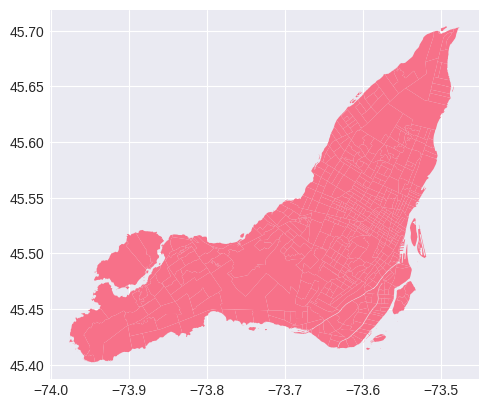

In [7]:
census_df.plot()

## Fire data for Montreal

In [8]:
fires = pd.read_csv('sim_combined_df.csv', engine='python')
print(f"Total fire incidents: {len(fires):,}")
fires.head()

Total fire incidents: 395,971


,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE,CREATION_DATE_FIXED,NOM_ARROND_2,YearMonth,Month,Year,DayOfWeek,"CREATION_DATE_FIXED"""
0,20074,2018/02/22,Alarme privé ou locale,Alarmes-incendies,20,Montréal,Ville-Marie,6,4.0,300599.1,5041118.2,-73.553764,45.509971,2018-02-22,Ville-Marie,2018-02,2,2018,3,2018-02-22
1,45534,2018/05/10,Déchets en feu,AUTREFEU,55,Pointe-Claire,Indéterminé,2,1.0,281760.2,5035568.6,-73.794604,45.459666,2018-05-10,Pointe-Claire,2018-05,5,2018,3,2018-05-10
2,53654,2018/06/02,Appel de Cie de détection,Alarmes-incendies,5,Montréal,Ville-Marie,6,3.0,299523.5,5040741.7,-73.567526,45.506577,2018-06-02,Ville-Marie,2018-06,6,2018,5,2018-06-02
3,54060,2018/06/03,Alarme privé ou locale,Alarmes-incendies,19,Montréal,Ville-Marie,6,3.0,300950.6,5042619.3,-73.549277,45.523481,2018-06-03,Ville-Marie,2018-06,6,2018,6,2018-06-03
4,60405,2018/06/20,Appel de Cie de détection,Alarmes-incendies,76,Westmount,Indéterminé,14,3.0,297496.4,5039104.8,-73.593442,45.491828,2018-06-20,Westmount,2018-06,6,2018,2,2018-06-20


In [9]:
# Rename coordinate columns
fires.rename(columns={'LATITUDE': 'latitude', 'LONGITUDE': 'longitude'}, inplace=True)

# GeoDataFrame with WGS84 coordinates
fires_geo = gpd.GeoDataFrame(
    fires,
    geometry=gpd.points_from_xy(fires['longitude'], fires['latitude']),
    crs=4326
)

# Convert to NAD83/MTM8 to match grid
fires_geo = fires_geo.to_crs(epsg=32188)

# Convert date column and extract year-month
fires_geo['CREATION_DATE_FIXED'] = pd.to_datetime(fires_geo['CREATION_DATE_FIXED'])
fires_geo['year_month'] = fires_geo['CREATION_DATE_FIXED'].dt.to_period('M').astype(str)

print(f"Date range: {fires_geo['CREATION_DATE_FIXED'].min()} to {fires_geo['CREATION_DATE_FIXED'].max()}")
print(f"Year-month range: {fires_geo['year_month'].min()} to {fires_geo['year_month'].max()}")

Date range: 2005-01-01 00:00:00 to 2025-09-21 00:00:00
Year-month range: 2005-01 to 2025-09


<Axes: >

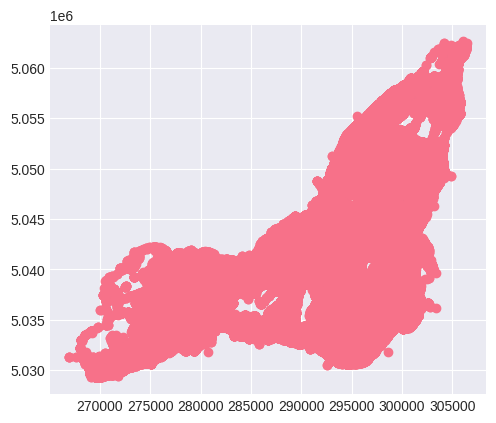

In [ ]:
fires_geo.plot()

In [10]:
print(census_df.crs)
print(fires_geo.crs)

EPSG:4326
EPSG:32188


In [11]:
#Project census tract data to match fire data
census_df = census_df.to_crs(epsg=32188)
print(census_df.crs)

EPSG:32188


## Join Census data with the Fire data

In [12]:
# census_fire_join = gpd.sjoin(fires_geo, census_df, how='left', predicate='within')
# census_fire_join.head()



# Spatial join
print("Joining fires to census...")
census_fire_join2 = gpd.sjoin(
    fires_geo,
    census_df,
    how="left",
    predicate="within"
)

print(f"Fires successfully joined: {census_fire_join2['geometry'].notna().sum():,}")
print(f"Fires without cell assignment: {census_fire_join2['geometry'].isna().sum():,}")

# Count fires per cell and month
print("Counting fires per cell and month...")
fire_counts2 = (
    census_fire_join2.groupby(['geometry', 'year_month'])
    .size()
    .reset_index(name='fire_count')
)

print(f"Total census-month combinations with fires: {len(fire_counts2):,}")

Joining fires to census...
Fires successfully joined: 395,971
Fires without cell assignment: 0
Counting fires per cell and month...
Total census-month combinations with fires: 333,999


In [ ]:
fire_counts2.tail()

,geometry,year_month,fire_count
333994,POINT (302608.517 5036666.023),2019-11,1
333995,POINT (302694 5036604),2014-01,1
333996,POINT (303326.37 5036218.183),2016-11,1
333997,POINT (302723.099 5036287.921),2015-07,1
333998,POINT (302723.099 5036287.921),2017-05,1


In [ ]:
census_fire_join2.geometry

,geometry
0,POINT (300599.072 5041118.147)
1,POINT (281760.193 5035568.558)
2,POINT (299523.441 5040741.781)
3,POINT (300950.591 5042619.298)
4,POINT (297496.428 5039104.748)
...,...
395966,POINT (271736.043 5031665.867)
395967,POINT (293934.754 5038697.94)
395968,POINT (294297.608 5038466.171)
395969,POINT (298695.81 5050403.306)


In [ ]:
fire_counts2.head()

,geometry,year_month,fire_count
0,POINT (266986.437 5031263.969),2018-07,1
1,POINT (266985.495 5031276.533),2016-10,1
2,POINT (266985.495 5031276.533),2023-06,1
3,POINT (266985.495 5031276.533),2025-08,1
4,POINT (267657.978 5031351.216),2006-03,1


### Rework: spatially join fire with census

In [13]:
# The fire_counts dataframe contains a geometry column which is the points or location where fire occurred instead of the geometry of the census tract.
# Moreover, there is no building sharing the same geometry or the same point as the fire incident location.

# If we use this geometry (point) column as the common attribute for merging other dataframes such as buildings, it will not work.
# So, I am reversing fires_geo and census_df in sjoin, and use predicate="contains".
# By doing so, the census_fire_join will have the geometry (polygon or multipolygon) from census_df, which is the census tract division.

# census_fire_join = gpd.sjoin(fires_geo, census_df, how='left', predicate='within')
# census_fire_join.head()



# Spatial join
print("Joining fires to census...")
census_fire_join = gpd.sjoin(
    census_df,
    fires_geo,
    how="left",
    predicate="contains"
)

print(f"Fires successfully joined: {census_fire_join['geometry'].notna().sum():,}")
print(f"Fires without cell assignment: {census_fire_join['geometry'].isna().sum():,}")

# Count fires per cell and month
print("Counting fires per cell and month...")
fire_counts = (
    census_fire_join.groupby(['geometry', 'year_month'])
    .size()
    .reset_index(name='fire_count')
)

print(f"Total census-month combinations with fires: {len(fire_counts):,}")

Joining fires to census...
Fires successfully joined: 395,775
Fires without cell assignment: 0
Counting fires per cell and month...
Total census-month combinations with fires: 112,311


In [14]:
fire_counts.iloc[100:200]

,geometry,year_month,fire_count
100,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2014-10,2
101,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2014-11,1
102,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2014-12,3
103,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2015-02,4
104,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2015-03,2
...,...,...,...
195,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2024-01,4
196,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2024-02,2
197,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2024-03,1
198,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2024-04,1


In [15]:
fire_counts.shape

(112311, 3)

In [16]:
census_fire_join.shape

(395775, 32)

In [17]:
# Count unique values of 'geometry' and 'year_month'
unique_geometries = fire_counts['geometry'].nunique()
unique_year_months = fire_counts['year_month'].nunique()

# Display the counts
print(f"Number of unique geometries: {unique_geometries:,}")
print(f"Number of unique year-months: {unique_year_months:,}")

Number of unique geometries: 541
Number of unique year-months: 249


In [18]:
# Count unique values of 'geometry' and 'year_month'
unique_geometries = census_fire_join['geometry'].nunique()
unique_year_months = census_fire_join['year_month'].nunique()

# Display the counts
print(f"Number of unique geometries: {unique_geometries:,}")
print(f"Number of unique year-months: {unique_year_months:,}")

Number of unique geometries: 541
Number of unique year-months: 249


## Join Census_Fire Data with Building data

In [ ]:
#load building data

# buildings
buildings = gpd.read_file('montreal_dataset_v1.geojson', engine='pyogrio')
#buildings = gpd.read_file('montreal_dataset_v1.geojson', engine='pyogrio')

print(f"Initial buildings: {len(buildings):,}")
print(f"Original CRS: {buildings.crs}")

# invalid construction years (9999 = missing)
buildings = buildings[buildings['ANNEE_CONS'] != 9999]
print(f"After filtering invalid construction years: {len(buildings):,}")

# Here, I convert to NAD83/MTM8 (EPSG:32188) to be in line with the projection used by city of Montreal

buildings = buildings.to_crs(epsg=32188)
print(f"Converted to CRS: {buildings.crs}")

Initial buildings: 480,243
Original CRS: EPSG:4326
After filtering invalid construction years: 466,775
Converted to CRS: EPSG:32188


In [ ]:
print(census_fire_join.crs)
print(buildings.crs)

EPSG:32188
EPSG:32188


In [ ]:


print("Converting buildings to points...")
buildings_points = buildings.copy()
buildings_points['geometry'] = buildings.representative_point()

# Spatial join
print("Joining buildings to grid...")
bld_with_census = gpd.sjoin(
    buildings_points,
    census_df['geometry'].drop_duplicates().reset_index(),
    how="left",
    predicate="within"
)

print(f"Buildings successfully joined: {bld_with_census['geometry'].notna().sum():,}")
print(f"Buildings without geometry assignment: {bld_with_census['geometry'].isna().sum():,}")

# Aggregate building attributes by cell
print("Aggregating building features by cell...")
bld_agg = (
    bld_with_census.groupby('geometry')
    .agg(
        num_buildings=('geometry', 'count'),
        avg_floors=('ETAGE_HORS', 'mean'),
        median_construction_year=('ANNEE_CONS', 'median')
    )
    .reset_index()
)

print(f"Geom with buildings: {len(bld_agg):,}")
print(f"\nBuilding statistics:")
print(bld_agg.describe())

Converting buildings to points...
Joining buildings to grid...
Buildings successfully joined: 466,775
Buildings without geometry assignment: 0
Aggregating building features by cell...
Geom with buildings: 316,485

Building statistics:
       num_buildings     avg_floors  median_construction_year
count  316485.000000  316485.000000             316485.000000
mean        1.474872       1.885530               1957.490262
std         8.109324       0.848858                 28.191513
min         1.000000       0.000000               1600.000000
25%         1.000000       2.000000               1946.000000
50%         1.000000       2.000000               1959.000000
75%         1.000000       2.000000               1975.000000
max      1169.000000      47.000000               2022.000000


In [ ]:
bld_agg.head()

,geometry,num_buildings,avg_floors,median_construction_year
0,POINT (268884.921 5030191.28),1,1.0,1975.0
1,POINT (268875.639 5030237.028),1,1.0,1960.0
2,POINT (268860.787 5030263.737),1,2.0,1996.0
3,POINT (268047.857 5031312.34),1,1.0,1910.0
4,POINT (268202.953 5031210.551),1,1.0,1906.0


In [ ]:
bld_with_census.geometry

,geometry
0,POINT (297366.115 5055179.028)
1,POINT (297401.536 5054764.709)
3,POINT (299308.412 5057583.998)
4,POINT (297920.87 5048788.792)
5,POINT (298660.299 5051848.351)
...,...
480238,POINT (275278.534 5034139.412)
480239,POINT (274563.412 5034712.349)
480240,POINT (274397.134 5035115.785)
480241,POINT (273183.58 5033913.094)


In [ ]:
bld_with_census.head()

,OBJECTID,OBJECTID_1,OBJECTID_12,Z_Min,Z_Max,Z_Mean,OBJECTID_12_13,ID_UEV,CIVIQUE_DE,CIVIQUE_FI,...,TARGET_FID_1,Shape_Leng_1,Shape_Area_1,MERGE_SRC,NewHieght,Shape_Length,Shape_Area,geometry,index_right0,index
0,1,1,1,24.80,36.73,32.352872,1,02005824,,,...,,,,,11,0.001077,3.134820e-08,POINT (297366.115 5055179.028),323,323
1,2,2,2,28.44,38.25,36.507502,3,02004842,,,...,,,,,9,0.000400,9.041729e-09,POINT (297401.536 5054764.709),323,323
3,4,4,4,15.10,23.66,21.400652,14,02010529,,,...,,,,,8,0.000639,2.213876e-08,POINT (299308.412 5057583.998),318,318
4,5,5,5,45.83,54.47,52.790334,16,02083902,,,...,,,,,9,0.000558,1.637121e-08,POINT (297920.87 5048788.792),508,508
5,6,6,6,34.49,43.32,41.246754,18,02038600,,,...,,,,,9,0.000487,1.321792e-08,POINT (298660.299 5051848.351),502,502


In [ ]:
bld_with_census.geometry

,geometry
0,POINT (297366.115 5055179.028)
1,POINT (297401.536 5054764.709)
3,POINT (299308.412 5057583.998)
4,POINT (297920.87 5048788.792)
5,POINT (298660.299 5051848.351)
...,...
480238,POINT (275278.534 5034139.412)
480239,POINT (274563.412 5034712.349)
480240,POINT (274397.134 5035115.785)
480241,POINT (273183.58 5033913.094)


## Rework: spatially join buildings with census_df

In [19]:
#load building data

# buildings
buildings = gpd.read_file('montreal_dataset_v1.geojson', engine='pyogrio')
#buildings = gpd.read_file('montreal_dataset_v1.geojson', engine='pyogrio')

print(f"Initial buildings: {len(buildings):,}")
print(f"Original CRS: {buildings.crs}")

# invalid construction years (9999 = missing)
buildings = buildings[buildings['ANNEE_CONS'] != 9999]
print(f"After filtering invalid construction years: {len(buildings):,}")

# Here, I convert to NAD83/MTM8 (EPSG:32188) to be in line with the projection used by city of Montreal

buildings = buildings.to_crs(epsg=32188)
print(f"Converted to CRS: {buildings.crs}")

Initial buildings: 480,243
Original CRS: EPSG:4326
After filtering invalid construction years: 466,775
Converted to CRS: EPSG:32188


In [20]:
print(census_fire_join.crs)
print(buildings.crs)

EPSG:32188
EPSG:32188


In [21]:
# Since the geometry is POINT, I am going to rework the sjoin



print("Converting buildings to points...")
buildings_points = buildings.copy()
buildings_points['geometry'] = buildings.representative_point()

# Spatial join
print("Joining buildings to grid...")
bld_with_census = gpd.sjoin(
    census_df['geometry'].drop_duplicates().reset_index(),
    buildings_points,
    how="left",
    predicate="contains"
)

print(f"Buildings successfully joined: {bld_with_census['geometry'].notna().sum():,}")
print(f"Buildings without geometry assignment: {bld_with_census['geometry'].isna().sum():,}")

# Aggregate building attributes by cell
print("Aggregating building features by cell...")
bld_agg = (
    bld_with_census.groupby('geometry')
    .agg(
        num_buildings=('geometry', 'count'),
        avg_floors=('ETAGE_HORS', 'mean'),
        median_construction_year=('ANNEE_CONS', 'median')
    )
    .reset_index()
)

print(f"Geom with buildings: {len(bld_agg):,}")
print(f"\nBuilding statistics:")
print(bld_agg.describe())

Converting buildings to points...
Joining buildings to grid...
Buildings successfully joined: 466,778
Buildings without geometry assignment: 0
Aggregating building features by cell...
Geom with buildings: 541

Building statistics:
       num_buildings  avg_floors  median_construction_year
count     541.000000  538.000000                538.000000
mean      862.805915    1.702445               1958.605019
std       596.021275    0.568000                 27.472547
min         1.000000    0.000000               1885.000000
25%       466.000000    1.492292               1943.250000
50%       721.000000    1.734832               1958.000000
75%      1073.000000    1.915877               1979.000000
max      4721.000000   12.250000               2016.000000


In [22]:
bld_with_census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 466778 entries, 0 to 540
Data columns (total 90 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   index                    466778 non-null  int64   
 1   geometry                 466778 non-null  geometry
 2   index_right              466775 non-null  float64 
 3   OBJECTID                 466775 non-null  float64 
 4   OBJECTID_1               466775 non-null  float64 
 5   OBJECTID_12              466775 non-null  float64 
 6   Z_Min                    466775 non-null  float64 
 7   Z_Max                    466775 non-null  float64 
 8   Z_Mean                   466775 non-null  float64 
 9   OBJECTID_12_13           466775 non-null  float64 
 10  ID_UEV                   466775 non-null  object  
 11  CIVIQUE_DE               466775 non-null  object  
 12  CIVIQUE_FI               466775 non-null  object  
 13  NOM_RUE                  466775 non-null  ob

In [23]:
bld_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   geometry                  541 non-null    geometry
 1   num_buildings             541 non-null    int64   
 2   avg_floors                538 non-null    float64 
 3   median_construction_year  538 non-null    float64 
dtypes: float64(2), geometry(1), int64(1)
memory usage: 17.0 KB


In [24]:
bld_with_census.head()

,index,geometry,index_right,OBJECTID,OBJECTID_1,OBJECTID_12,Z_Min,Z_Max,Z_Mean,OBJECTID_12_13,...,OBJECTID_12_13_14_15,OBJECTID_12_13_14_15_16,Join_Count_1,TARGET_FID_1,Shape_Leng_1,Shape_Area_1,MERGE_SRC,NewHieght,Shape_Length,Shape_Area
0,0,"POLYGON ((304266.999 5052304.004, 304238.008 5...",221323.0,221324.0,221324.0,221324.0,14.36,28.26,23.960944,38431.0,...,,,,,,,,15.0,0.002837,4.329091e-08
0,0,"POLYGON ((304266.999 5052304.004, 304238.008 5...",220318.0,220319.0,220319.0,220319.0,14.36,28.26,23.960944,36809.0,...,,,,,,,,15.0,0.002837,4.329091e-08
0,0,"POLYGON ((304266.999 5052304.004, 304238.008 5...",220493.0,220494.0,220494.0,220494.0,14.36,28.26,23.960944,37096.0,...,,,,,,,,15.0,0.002837,4.329091e-08
0,0,"POLYGON ((304266.999 5052304.004, 304238.008 5...",222303.0,222304.0,222304.0,222304.0,15.02,22.68,18.416097,40153.0,...,,,,,,,,9.0,0.000872,2.372280e-08
0,0,"POLYGON ((304266.999 5052304.004, 304238.008 5...",248567.0,248568.0,248568.0,248568.0,21.31,21.69,21.495152,79980.0,...,,,,,,,,8.0,0.000359,1.113782e-09


In [25]:
bld_agg.head()

,geometry,num_buildings,avg_floors,median_construction_year
0,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",717,1.748954,1932.0
1,"POLYGON ((273153.838 5033508.653, 273185.59 50...",651,1.651306,1992.0
2,"MULTIPOLYGON (((271226.004 5029331.998, 271224...",1433,1.521284,1960.0
3,"MULTIPOLYGON (((268388.005 5030336.995, 268388...",341,1.539589,1954.0
4,"MULTIPOLYGON (((270404.004 5036789.998, 270397...",1829,1.746309,2001.0


In [26]:
print(census_df.columns)
print(fires_geo.columns)
print(buildings.columns)

Index(['CTUID', 'DGUID', 'CTNAME', 'LANDAREA', 'PRUID', 'CA_Code',
       'ALT_GEO_CO', 'Population_density', 'Population_2021', 'geometry'],
      dtype='object')
Index(['INCIDENT_NBR', 'CREATION_DATE_TIME', 'INCIDENT_TYPE_DESC',
       'DESCRIPTION_GROUPE', 'CASERNE', 'NOM_VILLE', 'NOM_ARROND', 'DIVISION',
       'NOMBRE_UNITES', 'MTM8_X', 'MTM8_Y', 'longitude', 'latitude',
       'CREATION_DATE_FIXED', 'NOM_ARROND_2', 'YearMonth', 'Month', 'Year',
       'DayOfWeek', 'CREATION_DATE_FIXED"', 'geometry', 'year_month'],
      dtype='object')
Index(['OBJECTID', 'OBJECTID_1', 'OBJECTID_12', 'Z_Min', 'Z_Max', 'Z_Mean',
       'OBJECTID_12_13', 'ID_UEV', 'CIVIQUE_DE', 'CIVIQUE_FI', 'NOM_RUE',
       'SUITE_DEBU', 'MUNICIPALI', 'ETAGE_HORS', 'NOMBRE_LOG', 'ANNEE_CONS',
       'CODE_UTILI', 'LETTRE_DEB', 'LETTRE_FIN', 'LIBELLE_UT', 'CATEGORIE_',
       'MATRICULE8', 'SUPERFICIE', 'SUPERFIC_1', 'NO_ARROND_', 'Shape_Leng',
       'OBJECTID_2', 'Join_Count', 'TARGET_FID', 'feature_id', 'md_id',

In [27]:
# Count unique values of 'geometry' and 'year_month'
unique_geometries = bld_agg['geometry'].nunique()
##unique_year_months = bld_agg['year_month'].nunique()

# Display the counts
print(f"Number of unique geometries: {unique_geometries:,}")
##print(f"Number of unique year-months: {unique_year_months:,}")

Number of unique geometries: 541


In [ ]:
bld_with_census.describe()

,index,index_right,OBJECTID,OBJECTID_1,OBJECTID_12,Z_Min,Z_Max,Z_Mean,OBJECTID_12_13,ETAGE_HORS,...,Shape_Ar_1,OBJECTID_4,Join_Cou_1,TARGET_F_1,Shape_Le_2,Shape_Le_3,Shape_Ar_2,NewHieght,Shape_Length,Shape_Area
count,466778.000000,466775.000000,466775.000000,466775.000000,466775.000000,466775.000000,466775.000000,466775.000000,466775.000000,466775.000000,...,466775.0,466775.0,466775.0,466775.0,466775.0,466775.0,466775.0,466775.000000,466775.000000,4.667750e+05
mean,295.871335,240202.716313,240203.716313,240203.716313,240203.716313,36.971448,51.841666,46.810063,240178.899568,1.576599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.704329,0.001444,9.597559e-08
std,157.304817,139027.283374,139027.283374,139027.283374,139027.283374,86.333067,88.066094,86.799193,140022.908467,0.888990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.709750,0.003347,2.698384e-07
min,0.000000,0.000000,1.000000,1.000000,1.000000,-9999.000000,-9999.000000,-9999.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10134.000000,0.000002,9.030499e-14
25%,154.000000,119144.500000,119145.500000,119145.500000,119145.500000,24.640000,35.700000,32.819588,118817.500000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.000000,0.000497,1.272267e-08
50%,319.000000,240408.000000,240409.000000,240409.000000,240409.000000,35.570000,46.960000,43.493933,238934.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.000000,0.000624,1.764925e-08
75%,437.000000,360423.500000,360424.500000,360424.500000,360424.500000,47.810000,63.380000,58.441555,360867.500000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.000000,0.001259,6.676804e-08
max,540.000000,480242.000000,480243.000000,480243.000000,480243.000000,187.590000,417.270000,199.626126,483652.000000,47.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,401.000000,0.073415,1.546284e-05


## Panel Dataset

In [28]:
# Filter time range (September 2005 onwards)
print("Filtering time range...")
fire_counts = fire_counts[fire_counts['year_month'] >= '2005-09']
print(f"After filtering: {len(fire_counts):,} cell-month observations")

# Let's use pivot and stack (not MultiIndex)
print("Creating Panel Dataset...")
pivot_fire = fire_counts.pivot(
    index='geometry',
    columns='year_month',
    values='fire_count'
)

# Fill missing values with 0 (months with no fires)
pivot_fire = pivot_fire.fillna(0)

print(f"Cells: {len(pivot_fire)}")
print(f"Months: {len(pivot_fire.columns)}")
print(f"Total observations: {len(pivot_fire) * len(pivot_fire.columns):,}")

# Stack back to long format (ensures ALL cell-month combinations present)
final_fire = pivot_fire.stack().reset_index(name="number_of_fires")

print(f"\nPanel Dataset created: {len(final_fire):,} rows")

Filtering time range...
After filtering: 108,689 cell-month observations
Creating Panel Dataset...
Cells: 541
Months: 241
Total observations: 130,381

Panel Dataset created: 130,381 rows


In [29]:
pivot_fire

year_month,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,...,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09
geometry,,,,,,,,,,,,,,,,,,,,,
"MULTIPOLYGON (((268815.001 5029605.991, 268921...",3.0,4.0,0.0,2.0,4.0,2.0,3.0,3.0,10.0,4.0,...,0.0,1.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0
"POLYGON ((273153.838 5033508.653, 273185.59 50...",1.0,2.0,7.0,3.0,4.0,4.0,2.0,1.0,4.0,8.0,...,3.0,3.0,5.0,5.0,4.0,6.0,8.0,5.0,2.0,8.0
"MULTIPOLYGON (((271226.004 5029331.998, 271224...",9.0,8.0,4.0,7.0,3.0,5.0,4.0,4.0,3.0,8.0,...,3.0,6.0,2.0,7.0,3.0,5.0,10.0,7.0,8.0,4.0
"MULTIPOLYGON (((268388.005 5030336.995, 268388...",1.0,0.0,3.0,1.0,3.0,1.0,2.0,2.0,2.0,2.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,4.0,2.0,2.0
"MULTIPOLYGON (((270404.004 5036789.998, 270397...",0.0,0.0,2.0,1.0,1.0,1.0,3.0,2.0,1.0,4.0,...,5.0,2.0,3.0,5.0,1.0,3.0,5.0,3.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"POLYGON ((299831 5034943.995, 299651.785 50349...",2.0,2.0,1.0,4.0,1.0,0.0,0.0,2.0,1.0,2.0,...,3.0,3.0,2.0,3.0,2.0,1.0,6.0,4.0,6.0,3.0
"POLYGON ((299397.002 5034145.009, 299393.998 5...",1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,2.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,1.0
"POLYGON ((301166.453 5034817.308, 301176.39 50...",1.0,4.0,5.0,5.0,4.0,5.0,1.0,5.0,5.0,1.0,...,1.0,3.0,1.0,5.0,2.0,2.0,7.0,2.0,0.0,0.0


In [30]:
final_fire

,geometry,year_month,number_of_fires
0,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2005-09,3.0
1,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2005-10,4.0
2,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2005-11,0.0
3,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2005-12,2.0
4,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",2006-01,4.0
...,...,...,...
130376,"MULTIPOLYGON (((302344 5036840.995, 302338.994...",2025-05,5.0
130377,"MULTIPOLYGON (((302344 5036840.995, 302338.994...",2025-06,9.0
130378,"MULTIPOLYGON (((302344 5036840.995, 302338.994...",2025-07,11.0
130379,"MULTIPOLYGON (((302344 5036840.995, 302338.994...",2025-08,7.0


In [31]:
# Count unique values of 'geometry' and 'year_month'
unique_geometries = final_fire['geometry'].nunique()
unique_year_months = final_fire['year_month'].nunique()

# Display the counts
print(f"Number of unique geometries: {unique_geometries:,}")
print(f"Number of unique year-months: {unique_year_months:,}")

Number of unique geometries: 541
Number of unique year-months: 241


In [32]:
bld_agg

,geometry,num_buildings,avg_floors,median_construction_year
0,"MULTIPOLYGON (((268815.001 5029605.991, 268921...",717,1.748954,1932.0
1,"POLYGON ((273153.838 5033508.653, 273185.59 50...",651,1.651306,1992.0
2,"MULTIPOLYGON (((271226.004 5029331.998, 271224...",1433,1.521284,1960.0
3,"MULTIPOLYGON (((268388.005 5030336.995, 268388...",341,1.539589,1954.0
4,"MULTIPOLYGON (((270404.004 5036789.998, 270397...",1829,1.746309,2001.0
...,...,...,...,...
536,"POLYGON ((299831 5034943.995, 299651.785 50349...",449,2.398664,1925.0
537,"POLYGON ((299397.002 5034145.009, 299393.998 5...",607,1.922570,1930.0
538,"POLYGON ((301166.453 5034817.308, 301176.39 50...",1948,1.193018,2005.0
539,"POLYGON ((301314.858 5035940.906, 301343.563 5...",304,1.536184,1981.0


## Merge Features and Create Target Variable

In [33]:
# We need to merge temporal fire counts with static building features
print("Merging building features...")
fire_bld = final_fire.merge(bld_agg, on='geometry', how='left')

final_df = fire_bld.merge(census_df, on='geometry', how='left')

# Fill NaN values for cells with no buildings
final_df['num_buildings'] = final_df['num_buildings'].fillna(0)
final_df['avg_floors'] = final_df['avg_floors'].fillna(final_df['avg_floors'].median())
final_df['median_construction_year'] = final_df['median_construction_year'].fillna(
    final_df['median_construction_year'].median()
)

# Convert year_month to Period type for easier manipulation
final_df['year_month'] = pd.PeriodIndex(final_df['year_month'], freq='M')

# Sam - 25Oct25 - Start
# Updating the threshold used to define the target variable (updated to be 7 instead of 0)
# Create binary target variable: 1 if >7, 0 otherwise
final_df['Target_Variable'] = (final_df['number_of_fires'] > final_df['number_of_fires'].median()).astype(int)
#final_df['Target_Variable'] = (final_df['number_of_fires'] > 7).astype(int)
# Sam - 25Oct25 - End

print(f"\nFinal dataframe shape: {final_df.shape}")
print(f"\nColumns: {list(final_df.columns)}")
print(f"\nTarget variable distribution:")
print(final_df['Target_Variable'].value_counts(normalize=True))
print(f"\nFirst few rows:")
print(final_df.head(10))

Merging building features...

Final dataframe shape: (130381, 16)

Columns: ['geometry', 'year_month', 'number_of_fires', 'num_buildings', 'avg_floors', 'median_construction_year', 'CTUID', 'DGUID', 'CTNAME', 'LANDAREA', 'PRUID', 'CA_Code', 'ALT_GEO_CO', 'Population_density', 'Population_2021', 'Target_Variable']

Target variable distribution:
Target_Variable
0    0.560296
1    0.439704
Name: proportion, dtype: float64

First few rows:
                                            geometry year_month  \
0  MULTIPOLYGON (((268815.001 5029605.991, 268921...    2005-09   
1  MULTIPOLYGON (((268815.001 5029605.991, 268921...    2005-10   
2  MULTIPOLYGON (((268815.001 5029605.991, 268921...    2005-11   
3  MULTIPOLYGON (((268815.001 5029605.991, 268921...    2005-12   
4  MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-01   
5  MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-02   
6  MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-03   
7  MULTIPOLYGON (((26881

In [34]:
final_df.shape

(130381, 16)

In [35]:
median_fires = final_df['number_of_fires'].median()
print(f"The median of 'number_of_fires' in the final_df is: {median_fires}")

The median of 'number_of_fires' in the final_df is: 2.0


In [36]:
final_df[final_df['CTUID']=='4620001.00'].shape

(241, 16)

In [37]:
final_df.isna().sum()

,0
geometry,0
year_month,0
number_of_fires,0
num_buildings,0
avg_floors,0
median_construction_year,0
CTUID,0
DGUID,0
CTNAME,0
LANDAREA,0


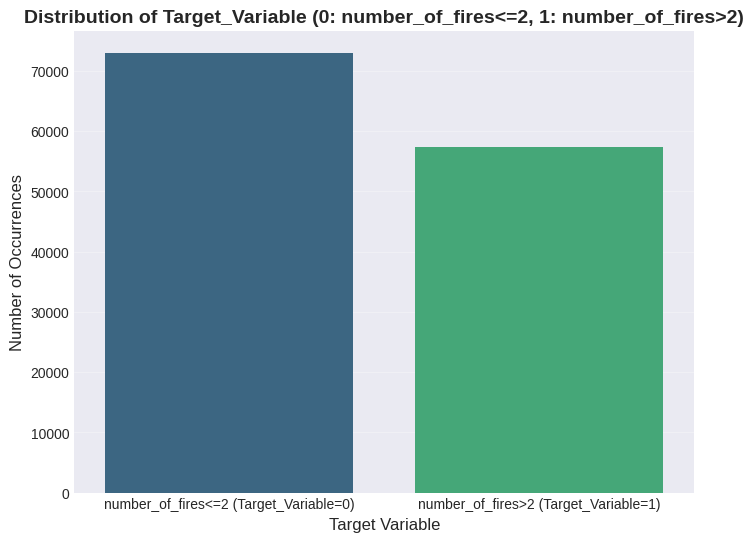

In [38]:
# Create a histogram of the Target_Variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Target_Variable', data=final_df, palette='viridis')
plt.title('Distribution of Target_Variable (0: number_of_fires<=2, 1: number_of_fires>2)', fontsize=14, fontweight='bold')
plt.xlabel('Target Variable', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['number_of_fires<=2 (Target_Variable=0)', 'number_of_fires>2 (Target_Variable=1)'])
plt.grid(axis='y', alpha=0.3)
plt.show()

## Temporal Lags (Feature Engineering)

In [39]:
# Sort by cell and time for lag computation
print("Creating temporal lag features...")
final_df = final_df.sort_values(['geometry', 'year_month'])

# Create lagged fire count variables (1, 2, 3, 6, 12 months)
for lag in [1, 2, 3, 6, 12]:
    final_df[f'fires_lag_{lag}m'] = (
        final_df
        .groupby('geometry')['number_of_fires']
        .shift(lag)
        .fillna(0)
    )
    print(f"Created fires_lag_{lag}m")

# Lagged binary target variables (for autoregressive models)
for lag in [1, 2, 3]:
    final_df[f'target_lag_{lag}m'] = (
        final_df
        .groupby('geometry')['Target_Variable']
        .shift(lag)
        .fillna(0)
    )
    print(f"Created target_lag_{lag}m")

print(f"\nTemporal lag features added successfully")
print(f"New shape: {final_df.shape}")

Creating temporal lag features...
Created fires_lag_1m
Created fires_lag_2m
Created fires_lag_3m
Created fires_lag_6m
Created fires_lag_12m
Created target_lag_1m
Created target_lag_2m
Created target_lag_3m

Temporal lag features added successfully
New shape: (130381, 24)


## Seasonality

In [40]:
# Extract month and year
print("Creating seasonality features...")
final_df['month'] = final_df['year_month'].dt.month
final_df['year'] = final_df['year_month'].dt.year

# Sine/cosine transformations for circular encoding
final_df['month_sin'] = np.sin(2 * np.pi * final_df['month'] / 12)
final_df['month_cos'] = np.cos(2 * np.pi * final_df['month'] / 12)

print("Seasonality features created:")
print("  - month (1-12)")
print("  - year")
print("  - month_sin (circular encoding)")
print("  - month_cos (circular encoding)")

#  Sample values for different months
print("\nSample seasonality values:")
example_months = final_df[['month', 'month_sin', 'month_cos']].drop_duplicates().sort_values('month')
print(example_months.head(12))

Creating seasonality features...
Seasonality features created:
  - month (1-12)
  - year
  - month_sin (circular encoding)
  - month_cos (circular encoding)

Sample seasonality values:
    month     month_sin     month_cos
4       1  5.000000e-01  8.660254e-01
5       2  8.660254e-01  5.000000e-01
6       3  1.000000e+00  6.123234e-17
7       4  8.660254e-01 -5.000000e-01
8       5  5.000000e-01 -8.660254e-01
9       6  1.224647e-16 -1.000000e+00
10      7 -5.000000e-01 -8.660254e-01
11      8 -8.660254e-01 -5.000000e-01
0       9 -1.000000e+00 -1.836970e-16
1      10 -8.660254e-01  5.000000e-01
2      11 -5.000000e-01  8.660254e-01
3      12 -2.449294e-16  1.000000e+00


## Spatial Lags (ERROR)

In [41]:
# Build neighbor mapping using the 'touches' predicate
print("Building spatial adjacency structure...")
neighbor_map = {}

# Get all unique census tract geometries and their corresponding CTUIDs
census_geometries = census_df[['geometry', 'CTUID']].drop_duplicates().set_index('CTUID')

# Iterate through each census tract
for ctuid, geometry in census_geometries['geometry'].items():
    # Find neighbors that touch the current census tract
    neighbors = census_geometries[census_geometries.geometry.touches(geometry)].index.tolist()
    neighbor_map[ctuid] = neighbors

print(f"Neighbor map created for {len(neighbor_map):,} cells")

# Analyze neighbor distribution to understand edge effects
neighbor_counts = {cell: len(neighbors) for cell, neighbors in neighbor_map.items()}
print("\nNeighbor count distribution:")
print(f"  Cells with 0 neighbors: {sum(1 for c in neighbor_counts.values() if c == 0)}")
print(f"  Cells with 1 neighbor: {sum(1 for c in neighbor_counts.values() if c == 1)}")
print(f"  Cells with 2 neighbors: {sum(1 for c in neighbor_counts.values() if c == 2)}")
print(f"  Cells with 3 neighbors: {sum(1 for c in neighbor_counts.values() if c == 3)}")
print(f"  Cells with 4 neighbors: {sum(1 for c in neighbor_counts.values() if c == 4)}")
print(f"  Cells with 5 neighbors: {sum(1 for c in neighbor_counts.values() if c == 5)}")
print(f"  Cells with 6 neighbors: {sum(1 for c in neighbor_counts.values() if c == 6)}")
print(f"  Cells with 7 neighbors: {sum(1 for c in neighbor_counts.values() if c == 7)}")
print(f"  Cells with 8 neighbors: {sum(1 for c in neighbor_counts.values() if c == 8)}")
print(f"  Cells with 9 neighbors: {sum(1 for c in neighbor_counts.values() if c == 9)}")
print(f"  Cells with 10 neighbors: {sum(1 for c in neighbor_counts.values() if c == 10)}")
print(f"  Cells with 11 neighbors: {sum(1 for c in neighbor_counts.values() if c == 11)}")
print(f"  Cells with 12 neighbors: {sum(1 for c in neighbor_counts.values() if c == 12)}")
print(f"  Cells with 13 neighbors: {sum(1 for c in neighbor_counts.values() if c == 13)}")
print(f"  Cells with 14 neighbors: {sum(1 for c in neighbor_counts.values() if c == 14)}")
print(f"  Cells with 15 neighbors: {sum(1 for c in neighbor_counts.values() if c == 15)}")
print(f"  Cells with 16 neighbors: {sum(1 for c in neighbor_counts.values() if c == 16)}")

Building spatial adjacency structure...
Neighbor map created for 541 cells

Neighbor count distribution:
  Cells with 0 neighbors: 2
  Cells with 1 neighbor: 1
  Cells with 2 neighbors: 9
  Cells with 3 neighbors: 43
  Cells with 4 neighbors: 64
  Cells with 5 neighbors: 97
  Cells with 6 neighbors: 126
  Cells with 7 neighbors: 93
  Cells with 8 neighbors: 53
  Cells with 9 neighbors: 28
  Cells with 10 neighbors: 13
  Cells with 11 neighbors: 5
  Cells with 12 neighbors: 3
  Cells with 13 neighbors: 1
  Cells with 14 neighbors: 0
  Cells with 15 neighbors: 2
  Cells with 16 neighbors: 1


In [ ]:
# Compute spatial lag with TEMPORAL LAG to avoid data leakage

print("\nComputing spatial lag features with temporal lag (this may take a few minutes)...")


def get_neighbor_fires_lagged(row):
    """
    Sum of fire counts in neighboring cells from PREVIOUS month.
    This avoids data leakage by not using concurrent fire information.
    """
    cell_ctuid = row['CTUID']
    current_period = row['year_month']
    neighbors = neighbor_map.get(cell_ctuid, [])

    if len(neighbors) == 0:
        return 0

    # Get previous month (temporal lag)
    current_date = pd.to_datetime(str(current_period))
    previous_period = (current_date - pd.DateOffset(months=1)).to_period('M')

    neighbor_data = final_df[
        (final_df['CTUID'].isin(neighbors)) &
        (final_df['year_month'] == previous_period)
    ]

    return neighbor_data['number_of_fires'].sum()

def get_neighbor_targets_lagged(row):
    """
    Number of neighboring cells with fires in PREVIOUS month.
    This avoids data leakage by not using concurrent fire information.
    """
    cell_ctuid = row['CTUID']
    current_period = row['year_month']
    neighbors = neighbor_map.get(cell_ctuid, [])

    if len(neighbors) == 0:
        return 0

    # Get previous month (temporal lag)
    current_date = pd.to_datetime(str(current_period))
    previous_period = (current_date - pd.DateOffset(months=1)).to_period('M')

    neighbor_data = final_df[
        (final_df['CTUID'].isin(neighbors)) &
        (final_df['year_month'] == previous_period)
    ]

    return neighbor_data['Target_Variable'].sum()

def get_neighbor_count(row):
    """Number of valid neighbors for this cell (to identify border cells)"""
    cell_ctuid = row['CTUID']
    neighbors = neighbor_map.get(cell_ctuid, [])
    return len(neighbors)

# Spatial lag computation
print("Computing spatial lag features...")
final_df['neighbors_fires_lag1m'] = final_df.apply(get_neighbor_fires_lagged, axis=1)
final_df['neighbors_target_lag1m'] = final_df.apply(get_neighbor_targets_lagged, axis=1)
final_df['neighbor_count'] = final_df.apply(get_neighbor_count, axis=1)

# Normalized version (average per neighbor to handle edge effects)
final_df['neighbors_fires_avg'] = final_df['neighbors_fires_lag1m'] / final_df['neighbor_count']
final_df['neighbors_fires_avg'] = final_df['neighbors_fires_avg'].fillna(0)

print("\nSpatial lag features created:")
print("   neighbors_fires_lag1m (sum of fires in adjacent cells from previous month)")
print("   neighbors_target_lag1m (count of adjacent cells with fires from previous month)")
print("   neighbor_count (number of valid neighbors - identifies border cells)")
print("   neighbors_fires_avg (average fires per neighbor - normalized for edge effects)")

print(f"\nSpatial lag statistics:")
print(final_df[['neighbors_fires_lag1m', 'neighbors_target_lag1m', 'neighbor_count', 'neighbors_fires_avg']].describe())

In [50]:
# Install the RAPIDS libraries (including cuDF) in Google Colab
import sys, os, shutil

# Set the desired CUDA version for RAPIDS compatibility.
# Colab typically runs with a specific CUDA version (e.g., 11.8, 12.0, or 12.2).
# You should check the current CUDA version in your Colab runtime with !nvcc -V
# For this example, we'll use a common, recent version for RAPIDS: 23.10
# Replace '23.10' with the latest stable release or the one compatible with your environment.
RAPIDS_VERSION = '23.10'

# A known working version of the setup script for Colab
!pip install -q condacolab
import condacolab
condacolab.install()

# Install the desired RAPIDS version from the rapidsai channel
# This command installs the core libraries like cuDF, cuML, etc.
# We are only installing cudf in this example to save time, but often cuML is useful too.
!conda install -c rapidsai -c nvidia -c conda-forge \
  rapids={RAPIDS_VERSION} python=3.10 cuda-version=11.8 -y

# You may need to restart the runtime after this cell runs for the changes to take effect.
print("\n--- Installation Complete ---")
print("You may need to manually restart the Colab runtime (Runtime -> Restart Runtime) for cuDF to be fully available.")



⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...
Channels:
 - rapidsai
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: / failed

SpecsConfigurationConflictError: Requested specs conflict with configured specs.
  requested specs: 
    - cuda-version=11.8
    - python=3.10
    - rapids=23.10
  pinned specs: 
    - cuda-version=12
    - python=3.12
    - python_abi=3.12[build=*cp312*]
Use 'conda config --show-sources' to look for 'pinned_specs' and 'track_features'
configuration parameters.  Pinned specs may also be defined in the file
/usr/local/conda-meta/pinned.



--- Installation Complete ---
You may need to manually restart the Colab runtime (Runtime -> Restart Runtime) for cuDF to be fully available.


In [2]:


import cudf
import pandas as pd # Still needed for date arithmetic, though cuDF is improving in this area
from datetime import timedelta

# --- ASSUMPTIONS & SETUP ---
# 1. 'final_df' is your main DataFrame (assumed to be a pandas DataFrame initially).
# 2. 'neighbor_map' is a dictionary mapping CTUID to a list of neighbor CTUIDs.
# 3. 'Target_Variable' is a column in final_df (implied target for neighbor_targets_lagged).

print("\nConverting data to cuDF for GPU processing...")

# 1. Convert pandas DataFrame to cuDF DataFrame
# Assuming final_df is a pandas DataFrame that has been loaded/processed
# final_df = pd.DataFrame(...) # Placeholder for your actual data loading
gdf = cudf.DataFrame.from_pandas(final_df)

# Convert neighbor_map into a cuDF friendly format: a list of (CTUID, neighbor_CTUID) pairs.
# This structure is needed for an efficient join operation.
neighbor_list = []
for cell_ctuid, neighbors in neighbor_map.items():
    for neighbor_ctuid in neighbors:
        neighbor_list.append((cell_ctuid, neighbor_ctuid))

# Create a 'mapping' cuDF DataFrame for the neighbors
neighbor_map_gdf = cudf.DataFrame(neighbor_list, columns=['CTUID', 'neighbor_CTUID'])

print("Data conversion complete. Starting GPU computation...")

# --- TEMPORAL LAG CALCULATION ---

# Convert the year_month Period column (or string/int) to a datetime object for arithmetic
# Using Pandas for date/period conversion as cuDF's period handling is limited.
# For efficiency, we only compute the date logic once on a minimal set of data if possible,
# or better, do it on the whole column.
# Note: cuDF now supports some datetime operations, but for complex Period/Offset logic,
# using a pandas Series and then converting back is often the most reliable method.

# We'll use a pandas Series for the calculation and then convert to cuDF
period_series = gdf['year_month'].astype(str).to_pandas().apply(lambda x: pd.to_datetime(x).to_period('M'))
# Calculate the lagged period
previous_period_series = (period_series.apply(lambda x: pd.to_datetime(str(x))) - pd.DateOffset(months=1)).dt.to_period('M')

# Add the lagged period back to the cuDF DataFrame
gdf['previous_period'] = cudf.Series(previous_period_series.astype(str)) # Convert to string for an efficient join key
gdf['year_month_str'] = gdf['year_month'].astype(str) # Convert current period to string for matching

# --- SPATIAL LAG CALCULATION (GPU-accelerated) ---

print("Computing spatial lag features with temporal lag...")

# 1. Prepare the lagged data source: data from the PREVIOUS month
# We need the 'number_of_fires' and 'Target_Variable' for the previous month
# The lagged data should be indexed by its CTUID and its time period.
lagged_source_gdf = gdf[['CTUID', 'year_month_str', 'number_of_fires', 'Target_Variable']].copy()
lagged_source_gdf.rename(columns={
    'CTUID': 'neighbor_CTUID',
    'year_month_str': 'lagged_year_month_str',
    'number_of_fires': 'neighbor_fires_lagged',
    'Target_Variable': 'neighbor_target_lagged'
}, inplace=True)

# 2. Join the main dataframe with the neighbor map to get all (cell, neighbor) pairs
# This is a key step, efficiently done on the GPU.
# We join the 'main' data on 'CTUID' with the 'neighbor_map_gdf'
joined_neighbors_gdf = gdf.merge(neighbor_map_gdf, on='CTUID', how='left')

# 3. Join the result with the lagged source data
# We join on (neighbor_CTUID, previous_period) to get the neighbor's fire data from the previous month
final_join_gdf = joined_neighbors_gdf.merge(
    lagged_source_gdf,
    left_on=['neighbor_CTUID', 'previous_period'],
    right_on=['neighbor_CTUID', 'lagged_year_month_str'],
    how='left'
)

# 4. Group by the original unique identifier (CTUID, year_month) and aggregate
# The .fillna(0) before the sum ensures that cells with no valid neighbors/lagged data contribute 0.
spatial_lag_features = final_join_gdf.groupby(['CTUID', 'year_month']).agg({
    'neighbor_fires_lagged': 'sum',
    'neighbor_target_lagged': 'sum',
    'neighbor_CTUID': 'count' # Count of neighbors for the cell-period
}).reset_index()

# Rename the aggregated columns
spatial_lag_features.rename(columns={
    'neighbor_fires_lagged': 'neighbors_fires_lag1m',
    'neighbor_target_lagged': 'neighbors_target_lag1m',
    'neighbor_CTUID': 'neighbor_count'
}, inplace=True)

# 5. Merge the results back into the main DataFrame 'gdf'
gdf = gdf.merge(
    spatial_lag_features[['CTUID', 'year_month', 'neighbors_fires_lag1m', 'neighbors_target_lag1m', 'neighbor_count']],
    on=['CTUID', 'year_month'],
    how='left'
)

# Fill NaNs from the merge (cells with no neighbors won't have a match, should be 0)
gdf[['neighbors_fires_lag1m', 'neighbors_target_lag1m', 'neighbor_count']] = \
    gdf[['neighbors_fires_lag1m', 'neighbors_target_lag1m', 'neighbor_count']].fillna(0)


# --- NORMALIZATION ---

# Normalized version (average per neighbor to handle edge effects)
# This is also GPU accelerated now!
gdf['neighbors_fires_avg'] = gdf['neighbors_fires_lag1m'] / gdf['neighbor_count']
gdf['neighbors_fires_avg'] = gdf['neighbors_fires_avg'].fillna(0)


# --- OUTPUT & VERIFICATION ---
print("\nSpatial lag features created:")
print("   neighbors_fires_lag1m (sum of fires in adjacent cells from previous month)")
print("   neighbors_target_lag1m (count of adjacent cells with fires from previous month)")
print("   neighbor_count (number of valid neighbors - identifies border cells)")
print("   neighbors_fires_avg (average fires per neighbor - normalized for edge effects)")

print(f"\nSpatial lag statistics:")
# To show the statistics, we can use the cuDF describe method directly.
# Using .head().to_pandas() to show a sample result cleanly in the console
print(gdf[['neighbors_fires_lag1m', 'neighbors_target_lag1m', 'neighbor_count', 'neighbors_fires_avg']].describe())

# If you need to continue processing with a pandas DataFrame:
# final_df = gdf.to_pandas()
# print("\nConverted back to pandas for final analysis.")


Converting data to cuDF for GPU processing...


NameError: name 'final_df' is not defined

### Visualize Edge Effects and Spatial Structure (ERROR)

In [ ]:

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Neighbor Count Distribution
ax1 = axes[0, 0]
neighbor_dist = final_df.groupby('cell_id')['neighbor_count'].first()
counts = neighbor_dist.value_counts().sort_index()
ax1.bar(counts.index, counts.values, color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'])
ax1.set_xlabel('Number of Neighbors', fontsize=12)
ax1.set_ylabel('Number of Cells', fontsize=12)
ax1.set_title('Spatial Grid: Neighbor Count Distribution\n(Shows Edge Effects)', fontsize=14, fontweight='bold')
ax1.set_xticks([2, 3, 4])
for i, v in enumerate(counts.values):
    ax1.text(counts.index[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Spatial Lag Comparison: Original vs Lagged
ax2 = axes[0, 1]
# Sample a subset for visualization
sample_data = final_df.sample(min(1000, len(final_df)), random_state=42)
ax2.scatter(sample_data['neighbors_fires_lag1m'], sample_data['number_of_fires'],
           alpha=0.5, s=30, color='#3498db')
ax2.set_xlabel('Neighbor Fires (Previous Month)', fontsize=12)
ax2.set_ylabel('Current Cell Fires', fontsize=12)
ax2.set_title('Spatial-Temporal Relationship\n(Lagged Neighbor Fires vs Current Fires)',
             fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Correlation
corr = sample_data[['neighbors_fires_lag1m', 'number_of_fires']].corr().iloc[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {corr:.3f}',
        transform=ax2.transAxes, fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        verticalalignment='top')

# Edge Effect Analysis
ax3 = axes[1, 0]
edge_analysis = final_df.groupby('neighbor_count').agg({
    'number_of_fires': 'mean',
    'neighbors_fires_lag1m': 'mean',
    'neighbors_fires_avg': 'mean'
}).reset_index()

x = range(len(edge_analysis))
width = 0.35
ax3.bar([i - width/2 for i in x], edge_analysis['number_of_fires'],
       width, label='Avg Fires in Cell', color='#e74c3c', alpha=0.8)
ax3.bar([i + width/2 for i in x], edge_analysis['neighbors_fires_avg'].fillna(0) * 4,
       width, label='Avg Neighbor Fires (scaled)', color='#3498db', alpha=0.8)

ax3.set_xlabel('Number of Neighbors', fontsize=12)
ax3.set_ylabel('Average Fire Count', fontsize=12)
ax3.set_title('Fire Risk by Neighbor Count\n(Border vs Interior Cells)',
             fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(edge_analysis['neighbor_count'])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Time Series: Spatial Lag Feature Evolution
ax4 = axes[1, 1]
# Aggregate by month
monthly_spatial = final_df.groupby('year_month').agg({
    'neighbors_fires_lag1m': 'mean',
    'number_of_fires': 'mean'
}).reset_index()

# Convert period to datetime for plotting
monthly_spatial['date'] = monthly_spatial['year_month'].dt.to_timestamp()

ax4.plot(monthly_spatial['date'], monthly_spatial['number_of_fires'],
        label='Current Cell Fires', linewidth=2, color='#e74c3c')
ax4.plot(monthly_spatial['date'], monthly_spatial['neighbors_fires_lag1m'],
        label='Neighbor Fires (Lag 1m)', linewidth=2, color='#3498db', linestyle='--')

ax4.set_xlabel('Time', fontsize=12)
ax4.set_ylabel('Average Fire Count', fontsize=12)
ax4.set_title('Temporal Evolution: Spatial Lag Features\n(Monthly Averages)',
             fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [ ]:
# Summary statistics
print("\n" + "="*80)
print("EDGE EFFECTS ANALYSIS")
print("="*80)
print("\nFire statistics by neighbor count:")
edge_stats = final_df.groupby('neighbor_count').agg({
    'number_of_fires': ['mean', 'median', 'std'],
    'neighbors_fires_lag1m': ['mean', 'median'],
    'cell_id': 'nunique'
}).round(2)
edge_stats.columns = ['_'.join(col).strip() for col in edge_stats.columns.values]
print(edge_stats)



## Data Quality Checks

In [ ]:
# Missing values
print("\nMissing values:")
missing = final_df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("   No missing values found")




Missing values:
   No missing values found


In [ ]:
# Duplicate records
print("\nDuplicate records:")
duplicates = final_df.duplicated(subset=['geometry', 'year_month']).sum()
print(f"   Duplicate rows: {duplicates}")
if duplicates > 0:
    print("   Removing duplicates...")
    final_df = final_df.drop_duplicates(subset=['geometry', 'year_month'])




Duplicate records:
   Duplicate rows: 0


In [ ]:
# Temporal coverage
print("\nTemporal coverage:")
coverage = final_df.groupby('geometry')['year_month'].count()
print(f"   Min observations per cell: {coverage.min()}")
print(f"   Max observations per cell: {coverage.max()}")
print(f"   Mean observations per cell: {coverage.mean():.2f}")




Temporal coverage:
   Min observations per cell: 241
   Max observations per cell: 241
   Mean observations per cell: 241.00


In [ ]:
# Class balance
print("\nTarget variable class balance:")
class_dist = final_df['Target_Variable'].value_counts(normalize=True)
print(f"   No fire (0): {class_dist[0]:.2%}")
print(f"   Fire (1): {class_dist[1]:.2%}")

#print(f"   number_of_fires<=7 (0): {class_dist[0]:.2%}")
#print(f"   number_of_fires>7 (1): {class_dist[1]:.2%}")




Target variable class balance:
   No fire (0): 56.03%
   Fire (1): 43.97%


In [ ]:
# Data types
print("\nData types:")
print(final_df.dtypes)




Data types:
geometry                     geometry
year_month                  period[M]
number_of_fires               float64
num_buildings                   int64
avg_floors                    float64
median_construction_year      float64
CTUID                          object
DGUID                          object
CTNAME                         object
LANDAREA                      float64
PRUID                           int32
CA_Code                        object
ALT_GEO_CO                     object
Population_density            float64
Population_2021               float64
Target_Variable                 int64
fires_lag_1m                  float64
fires_lag_2m                  float64
fires_lag_3m                  float64
fires_lag_6m                  float64
fires_lag_12m                 float64
target_lag_1m                 float64
target_lag_2m                 float64
target_lag_3m                 float64
month                           int64
year                            int64

In [ ]:
# Summary statistics
print("\nSummary statistics:")
print(final_df.describe())


Summary statistics:
       number_of_fires  num_buildings     avg_floors  \
count    130381.000000  130381.000000  130381.000000   
mean          2.932337     862.805915       1.702624   
std           3.172500     595.472452       0.565903   
min           0.000000       1.000000       0.000000   
25%           1.000000     466.000000       1.493406   
50%           2.000000     721.000000       1.734832   
75%           4.000000    1073.000000       1.914945   
max          56.000000    4721.000000      12.250000   

       median_construction_year       LANDAREA     PRUID  Population_density  \
count             130381.000000  130381.000000  130381.0       130381.000000   
mean                1958.601664       0.921057      24.0         8569.840665   
std                   27.370938       1.659295       0.0         5812.470950   
min                 1885.000000       0.037100      24.0            0.000000   
25%                 1944.000000       0.245600      24.0         4377.4000

## Final Dataset Summary (ERROR)

In [ ]:
print("="*80)
print("FINAL DATASET SUMMARY")
print("="*80)

print(f"\nDataset shape: {final_df.shape[0]:,} rows x {final_df.shape[1]} columns")

print(f"\nSpatial coverage:")
print(f"  - Unique cells: {final_df['geometry'].nunique():,}")
print(f"  - Cell size: {CELL_SIZE}m x {CELL_SIZE}m")

print(f"\nTemporal coverage:")
print(f"  - Start date: {final_df['year_month'].min()}")
print(f"  - End date: {final_df['year_month'].max()}")
print(f"  - Total months: {final_df['year_month'].nunique()}")

print(f"\nTarget variable:")
# print(f"  - Total fire events: {final_df['Target_Variable'].sum():,}")
# print(f"  - Fire rate: {final_df['Target_Variable'].mean():.2%}")

print(f"  - rows with number_of_fires>7: {final_df['Target_Variable'].sum():,}")
print(f"  - rate of number_of_fires>7: {final_df['Target_Variable'].mean():.2%}")

print(f"\nFeature categories:")
print(f"  Spatial identifiers: cell_id")
print(f"  Temporal identifiers: year_month, year, month")
print(f"  Target: Target_Variable, number_of_fires")
print(f"  Building features: num_buildings, avg_floors, median_construction_year")
print(f"  Temporal lags: fires_lag_1m, fires_lag_2m, fires_lag_3m, fires_lag_6m, fires_lag_12m")
print(f"  Target lags: target_lag_1m, target_lag_2m, target_lag_3m")
print(f"  Seasonality: month_sin, month_cos")
print(f"  Spatial lags (with temporal lag): neighbors_fires_lag1m, neighbors_target_lag1m")
print(f"  Spatial features: neighbor_count, neighbors_fires_avg")

print(f"\nColumn list:")
for i, col in enumerate(final_df.columns, 1):
    print(f"  {i:2d}. {col}")


print("\n" + "="*80)
print("Data preparation complete!")
print("="*80)

FINAL DATASET SUMMARY

Dataset shape: 130,381 rows x 20 columns

Spatial coverage:
  - Unique cells: 541


NameError: name 'CELL_SIZE' is not defined

## Export Final Dataset (not run yet)

In [ ]:
# Convert year_month to string for export
final_df_export = final_df.copy()
final_df_export['year_month'] = final_df_export['year_month'].astype(str)

# Export to CSV
#csv_path = 'Data/fire_risk_panel_data.csv'
#csv_path = 'fire_risk_panel_data_201025.csv'
csv_path = 'fire_risk_panel_data_251025.csv'
print(f"Exporting to CSV: {csv_path}")
final_df_export.to_csv(csv_path, index=False)
print(f"CSV export complete. File size: {pd.read_csv(csv_path).memory_usage(deep=True).sum() / 1024**2:.2f} MB")



In [ ]:
# Export to Parquet

#parquet_path = 'Data/fire_risk_panel_data.parquet'
#parquet_path = 'fire_risk_panel_data_201025.parquet'
parquet_path = 'fire_risk_panel_data_251025.parquet'

print(f"\nExporting to Parquet: {parquet_path}")
final_df_export.to_parquet(parquet_path, index=False, compression='snappy', engine='pyarrow')
print(f"Parquet export complete.")


Exporting to Parquet: fire_risk_panel_data_251025.parquet


NameError: name 'final_df_export' is not defined

In [ ]:
print(f"\nDataset successfully exported to:")
print(f"  {csv_path}")
print(f"  {parquet_path}")
print(f"\nAll done- now ready for model training.")

## Display Sample Data

In [ ]:
# Sample data
print("Sample data (first 20 rows):")
print(final_df.head(20))

print("\nSample data (random 10 rows with fires):")
print(final_df[final_df['Target_Variable'] == 1].sample(min(10, len(final_df[final_df['Target_Variable'] == 1]))))

Sample data (first 20 rows):
                                             geometry year_month  \
0   MULTIPOLYGON (((268815.001 5029605.991, 268921...    2005-09   
1   MULTIPOLYGON (((268815.001 5029605.991, 268921...    2005-10   
2   MULTIPOLYGON (((268815.001 5029605.991, 268921...    2005-11   
3   MULTIPOLYGON (((268815.001 5029605.991, 268921...    2005-12   
4   MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-01   
5   MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-02   
6   MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-03   
7   MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-04   
8   MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-05   
9   MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-06   
10  MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-07   
11  MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-08   
12  MULTIPOLYGON (((268815.001 5029605.991, 268921...    2006-09   
13  MULTIPOLYGON ((